In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
mpl.rc('axes', labelsize=16)
mpl.rc('axes', titlesize=18)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('legend', title_fontsize=16)
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import mutual_info_classif

from scipy.stats import percentileofscore

# Titanic - Machine Learning from Disaster
This is the legendary Titanic ML competition on [Kaggle](https://www.kaggle.com/c/titanic)

## Goal
To predict if a passanger survived the sinking of the Titanic or not.

## Crrent Solutions
There are dosens of solutions available on the [discussion forum](https://www.kaggle.com/c/titanic/discussion) and on the Internet.

## Frame the Problem
- Supervised learning
- Classification
- Binary classification (survived of not)
- Batch learning (no continuous flow of data and the dataset is small)

## Performance metrics
**The percentage of correctly predicted passengers** (accuracy).

There are also several useful metrics for evaluating the performance of a classification system:
- precision,
- recall,
- $F_1$ score,
- precision/recall curve,
- ROC curve,
- ROC AUC score.

## Target performance
The leaderboard of this competition contains almost 14000 entries. 
The median score is about 0.775, but less than 3% of the solutions have a score above 0.8. 
Thus, **an accuracy score equal to or greater than 0.8 would be a very good result**.

In [2]:
leaderboard = pd.read_csv('../datasets/titanic-publicleaderboard.csv')
leaderboard.head()

,TeamId,TeamName,SubmissionDate,Score
0,6987444,no name,2022-08-23 18:16:28,1.0
1,720238,rosh,2022-06-26 10:58:42,1.0
2,8814675,nikolai otvetchikov #2,2022-06-26 13:59:39,1.0
3,8821160,Vibhav Rathkanthiwar,2022-06-26 15:28:12,1.0
4,6590016,Osman Altuntas,2022-07-24 15:40:15,1.0


In [3]:
leaderboard.Score.describe()

count    13915.000000
mean         0.760751
std          0.075145
min          0.000000
25%          0.765550
50%          0.775110
75%          0.777510
max          1.000000
Name: Score, dtype: float64

In [4]:
percentileofscore(leaderboard.Score, 0.8) / 100

0.9711821775062881

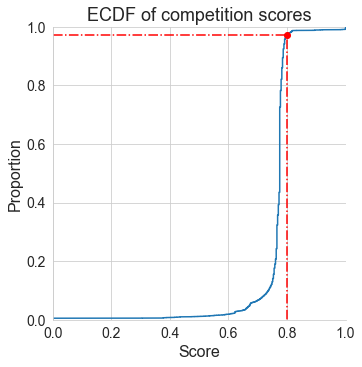

In [5]:
def plot_ecdf_with_target(data, target):
    sns.displot(data, stat='proportion', kind='ecdf', height=5, aspect=1)
    
    quantile = percentileofscore(data, target) / 100
    
    plt.plot([0, target, target], [quantile, quantile, 0], '-.r')
    plt.plot([target], [quantile], 'or')
    
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    
    plt.title('ECDF of competition scores')
    
    plt.show()

    
plot_ecdf_with_target(leaderboard.Score, 0.8)

In addition, there are several solutions with a score equal to 1.0. Have authors reached perfection?

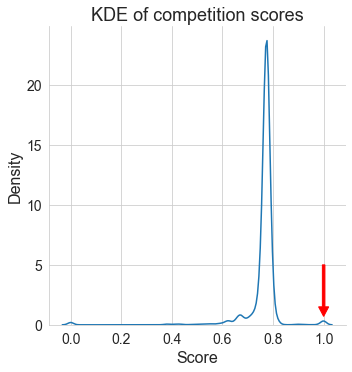

In [6]:
sns.displot(leaderboard, x='Score', kind='kde')
plt.arrow(x=1.0, y=5, dx=0, dy=-3.5, width=0.01, head_width=0.04, head_length=0.8, color='r')
plt.title("KDE of competition scores")

plt.show()

## Data Dictionary
0. **PassengerId** - Passenger ID.
1. **Survived** - Survival:
    - 0 = No, 
    - 1 = Yes.
2. **Pclass** - Ticket class:
    - 1 = 1st, 
    - 2 = 2nd, 
    - 3 = 3rd.
3. **Name** - Passanger's name, for example, "Braund, Mr. Owen Harris".
4. **Sex** - Gender:
    - male,
    - female.
5. **Age** - Age in years, for example 38.0.
6. **SibSp** - Number of siblings or spouses aboard the Titanic.
7. **Parch** - Number of parents or children aboard the Titanic.
8. **Ticket** - Ticket number, for example, A/5 21171.
9. **Fare** - Passenger fare, for ecample, 71.2833.
10. **Cabin** - Cabin number, for example, C85.
11. **Embarked** - Port of Embarkation:
    - C = Cherbourg,
    - Q = Queenstown,
    - S = Southampton.
    
### Features
PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket,
Fare, Cabin, Embarked

### Target
Survived
    
## Variable Notes
- **pclass**: socio-economic status
    - *1st* = Upper
    - *2nd* = Middle
    - *3rd* = Lower
- **age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- **sibsp**: number of sibling/spouses aboard the Titanic
    - *sibling* = brother, sister, stepbrother, stepsister
    - *spouse* = husband, wife (mistresses and fiancés were ignored)
- **parch**: number of parents (mother, father)/children (daughter, son, stepdauter, stepson) aboard the Titanic. Some children travelled only with a nanny, therefore parch=0 for them.

## File Paths
- **training set**: ../datasets/train.csv
- **test set**: ../datasets/test.csv
- **example of a submission file**: ../datasets/gender_submission.csv

## Assumptions
Women were more likely to survive than men.

## Load Data
### Traing data

In [7]:
data = pd.read_csv('../datasets/train.csv')

### Test set for submission

In [8]:
submission_X = pd.read_csv('../datasets/gender_submission.csv')

## Preliminary Analysis
### Shape of the dataset

In [9]:
data.shape

(891, 12)

### First rows of the dataset

In [10]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data types and non-null counts

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Number of missing values

In [12]:
data.isna().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Number of unique values
There are high-cardinality features with object dtype:
- Name
- Ticket
- Cabin

This features, possibly, will need special preprocessing.

The **"PassengerId"** feature is the ID of the passanger. 
It won't help in analysis and will be droped.

In [13]:
data.select_dtypes(include='object').nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [14]:
data.select_dtypes(exclude='object').nunique()

PassengerId    891
Survived         2
Pclass           3
Age             88
SibSp            7
Parch            7
Fare           248
dtype: int64

### Summary statistics

In [15]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
data.select_dtypes(include='object').describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Sample a Test Set

The test set will be used to evaluate performance of a very final model
and forecast the score in the competitions leaderboard. It may seems like
it's to early to create a test set, but I'll do it to prevent data snooping.

I'm going to do stratified sampling with scikit-learn's StratifiedShuffleSplit to maintain equal ratio of men and women in the train set and the test set. Women seem to have had a better chance of surviving due to the "women and children first" protocol for loading lifeboats.

First, let's check how many passengers survived.

Number of survived passengers 342, (38.38%)
Number of drowned passengers 549, (61.62%)


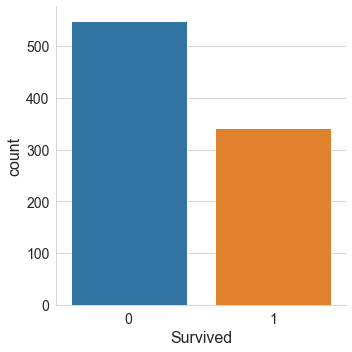

In [17]:
print(f'Number of survived passengers {data.Survived.sum()}, ({data.Survived.sum()/len(data):.2%})')
print(f'Number of drowned passengers {len(data) - data.Survived.sum()}, ({(len(data) - data.Survived.sum())/len(data):.2%})')
sns.catplot(data=data, x='Survived', kind='count')
# plt.savefig('../docs/images/number_of_survivors.pdf', bbox_inches='tight')
plt.show()

Next, let's check the proportion of women among the survivors.

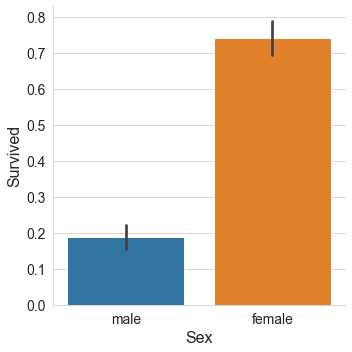

In [18]:
sns.catplot(data=data, x='Sex', y='Survived', kind='bar')
# plt.savefig('../docs/images/proportion_of_survived_women.pdf', bbox_inches='tight')
plt.show()

Let's check this assumption  for each passanger class.

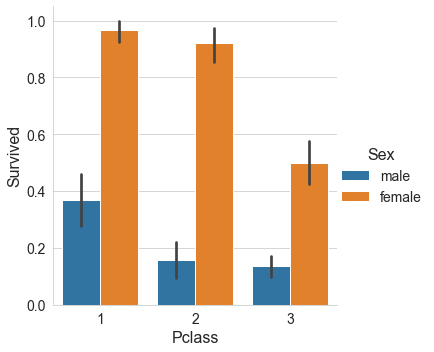

In [19]:
sns.catplot(data=data, x='Pclass', y='Survived', hue='Sex', kind='bar')
# plt.savefig('../docs/images/proportion_of_survived_women_among_pclasses.pdf',
#             bbox_inches='tight')
plt.show()

The assumtpion seems to be correct. Now, it's time to split dataset.

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data, data.Sex):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

https://ru.wikipedia.org/wiki/%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA

https://www.tensorflow.org/datasets/catalog/titanic

https://habr.com/ru/company/mlclass/blog/270973/

https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280

https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D1%81%D1%81%D0%B0%D0%B6%D0%B8%D1%80%D1%8B_%C2%AB%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA%D0%B0%C2%BB

https://www.openml.org/search?type=data&sort=runs&id=40945&status=active